<a href="https://www.kaggle.com/code/danielfourie/airlines-delay-eda-classification-66-xgb-ann?scriptVersionId=206197385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
# Filter all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airlines-delay/airlines_delay.csv


<center>
    <h1>Airlines Delay</h1>
    <img src="https://www.domesticflights-southafrica.co.za/wp-content/uploads/2016/05/what-are-your-rights-when-your-flight-is-delayed.jpg">
</center>

# <u><b>Data Reading and Cleaning</b></u>

In [2]:
#import the dataset
dataset = pd.read_csv('/kaggle/input/airlines-delay/airlines_delay.csv')

In [3]:
#Look at first 5 rows
dataset.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [4]:
#set Flight column as index
dataset.Flight = dataset.Flight.astype(int)
dataset.set_index('Flight',inplace=True)
dataset.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
Flight,,,,,,,
2313,1296.0,141.0,DL,ATL,HOU,1,0
6948,360.0,146.0,OO,COS,ORD,4,0
1247,1170.0,143.0,B6,BOS,CLT,3,0
31,1410.0,344.0,US,OGG,PHX,6,0
563,692.0,98.0,FL,BMI,ATL,4,0


**We have the following features:<br/>
Numerical:** Time, and Length<br/>
**Categorical:** Airline, AirportFrom, AirportTo, and DayOfWeek<br/>
**Note: we have assumed Time to be a numerical variable rather than a categorical one. We could have done the opposite as well, i.e. for this problem I do not see one as better than the other.**

In [5]:
#Let's look at the columns and their data type
dataset.dtypes

Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object

In [6]:
#Let's see the size of our dataset
dataset.shape

(539382, 7)

**We have 539382 rows and 7 columns**

In [7]:
#Let's see how many NaN values there are throughout our dataset
dataset.isnull().sum()

Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

**We have no missing data! This is good. Let's now look if there are any non-sensical values for the features.**

In [8]:
#Numerical features
numeric_features = ['Time','Length']
for feature in numeric_features:
    if len(dataset[dataset[feature] <= 0]) > 0: #if there are any zero or negative values
        print(f"There is at least one or more zeros or negative values for feature {feature}, and the min and max value is {min(dataset[feature])}, and {max(dataset[feature])} respectively")
    else:
        print(f"There are no zeros or negative values for feature {feature}, and the min and max value is {min(dataset[feature])}, and {max(dataset[feature])} respectively")

#Categorical features
for feature in ['Airline','AirportFrom','AirportTo']:
    if not pd.api.types.is_string_dtype(dataset[feature]): #Check if columns has non-string values
        print(f"Column '{feature}' has non-string values.")
    else:
        print(f"There are no non-string values in feature {feature}")
        
print(f"All values in feature DayOfWeek: {dataset['DayOfWeek'].unique().tolist()}")
print(f"All values in target feature Class: {dataset['Class'].unique().tolist()}")

There are no zeros or negative values for feature Time, and the min and max value is 10.0, and 1439.0 respectively
There is at least one or more zeros or negative values for feature Length, and the min and max value is 0.0, and 655.0 respectively
There are no non-string values in feature Airline
There are no non-string values in feature AirportFrom
There are no non-string values in feature AirportTo
All values in feature DayOfWeek: [1, 4, 3, 6, 7, 2, 5]
All values in target feature Class: [0, 1]


**We notice that our only problem feature is Length. We will see how many rows have zero or negative values and remove them from our dataset.**

In [9]:
#First check if our index Flight has any duplicates
print(f"There are {dataset.index.duplicated().sum()} duplicate/s in our index")

There are 532797 duplicate/s in our index


In [10]:
#Reset the index before dropping because index Flight is not unique
dataset.reset_index(inplace=True)
indexes_to_drop = dataset[dataset['Length'] <= 0].index
print(f"Number of rows to drop: {len(indexes_to_drop)}")
dataset.drop(index=indexes_to_drop, inplace=True)
#Set the index again
dataset.Flight = dataset.Flight.astype(int)
dataset.set_index('Flight',inplace=True)
#Let's see the size of our dataset
print(f"New dataset shape: {dataset.shape}")

Number of rows to drop: 4
New dataset shape: (539378, 7)


In [11]:
#change categorical columns to be a category data type
for col in dataset.columns:
    if col in ['Time','Length','Class']:
        next
    else:
        dataset[col] = dataset[col].astype('category')
dataset.dtypes

Time            float64
Length          float64
Airline        category
AirportFrom    category
AirportTo      category
DayOfWeek      category
Class             int64
dtype: object

**We now move onto EDA.**

# <u><b>Exploratory Data Analysis</b></u>

In [12]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

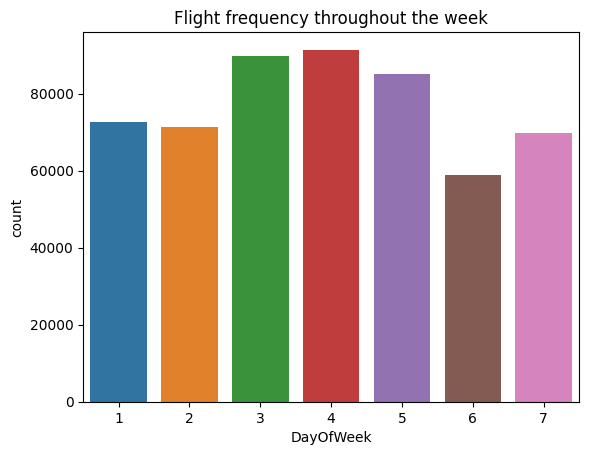

In [13]:
#Flight frequency throughout the week
DayOfWeekOrder = list(range(1,8))
sns.countplot(x='DayOfWeek',data=dataset,order=DayOfWeekOrder).set(title='Flight frequency throughout the week');

**We see that the middle days of the week is when the most flights are booked. Saturday has the least number of flights, while Thursday has the most. This can be explained by people wanting to fly to a new place and have a whole weekend to themselves.**

**Let's see the relationship between Day of week and Flight being delayed.**

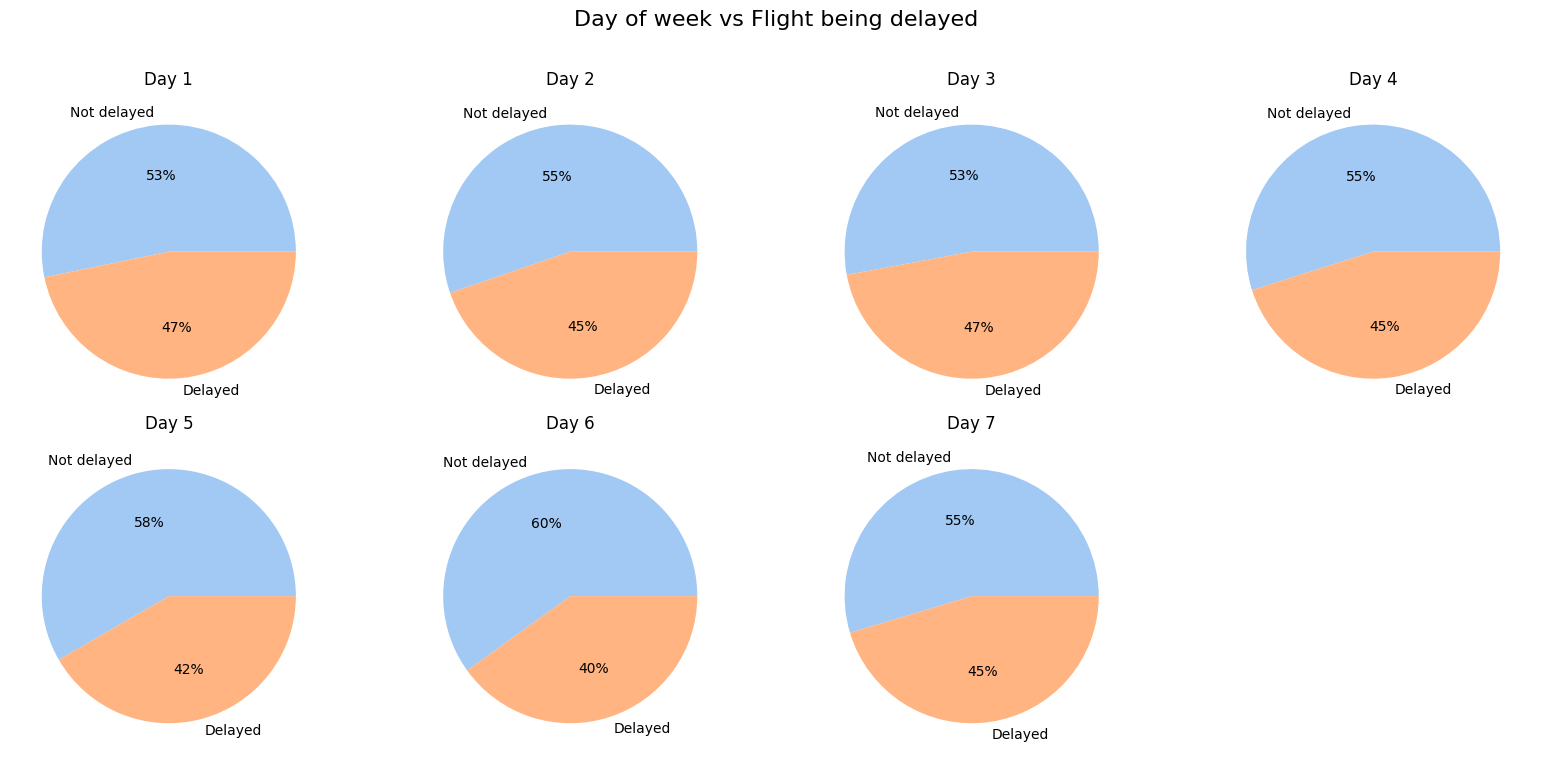

In [14]:
#Day of week vs Flight being delayed
a = dataset.groupby(['DayOfWeek','Class']).count().unstack('Class')['Time']
for i in range(a.shape[0]):
    numOfFlights = a.iloc[i,0]+a.iloc[i,1]
    for j in [0,1]:
        a.iloc[i,j] = a.iloc[i,j]/numOfFlights

#set labels for pie chart
pieChartLabels = ['Not delayed','Delayed']
#define Seaborn color palette to use
myColours = sns.color_palette('pastel')[0:5]

# Calculate the number of rows and columns for subplots dynamically
num_days = a.shape[0]
num_rows = (num_days - 1) // 4 + 1
num_cols = min(num_days, 4)

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 4 * num_rows))
fig.suptitle('Day of week vs Flight being delayed', fontsize=16)

# Iterate through days and create pie charts
for i in range(1, num_days + 1):
    b = a.iloc[i - 1, :]
    
    # Calculate the subplot position
    row_position = (i - 1) // num_cols
    col_position = (i - 1) % num_cols
    
    # Create pie chart in the specified subplot position
    axes[row_position, col_position].pie(b, labels=pieChartLabels, colors=myColours, autopct='%.0f%%')
    axes[row_position, col_position].set_title('Day ' + str(i))

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Remove any empty subplots if there are more subplots than days
if num_days < num_rows * num_cols:
    for i in range(num_days, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.show()

**We see that on days 5 and 6 we have the percentage of flights being the least delayed, and on days 1 and 3 we have it being the most delayed.**

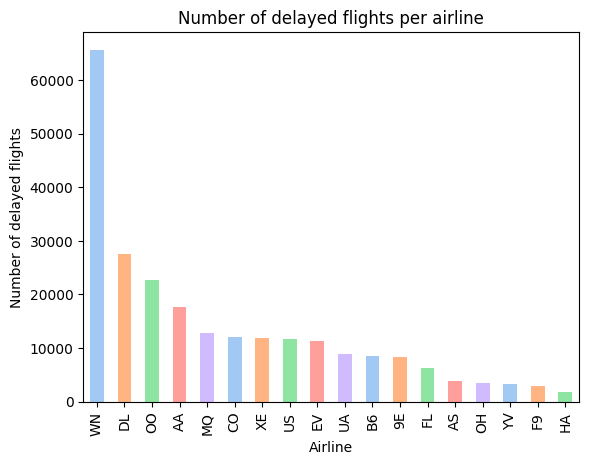

In [15]:
#We will now look at which airlines had the most delayed flights
c = dataset.groupby('Airline')['Class'].sum().sort_values(ascending=False)
c.plot(kind='bar',color=myColours)
plt.ylabel('Number of delayed flights')
plt.title('Number of delayed flights per airline')
plt.show()

**We see that airline WN has the most number of delayed flights by a big margin.**

**Lastly, we will look at the distribution of the numerical features Time, and Length.**

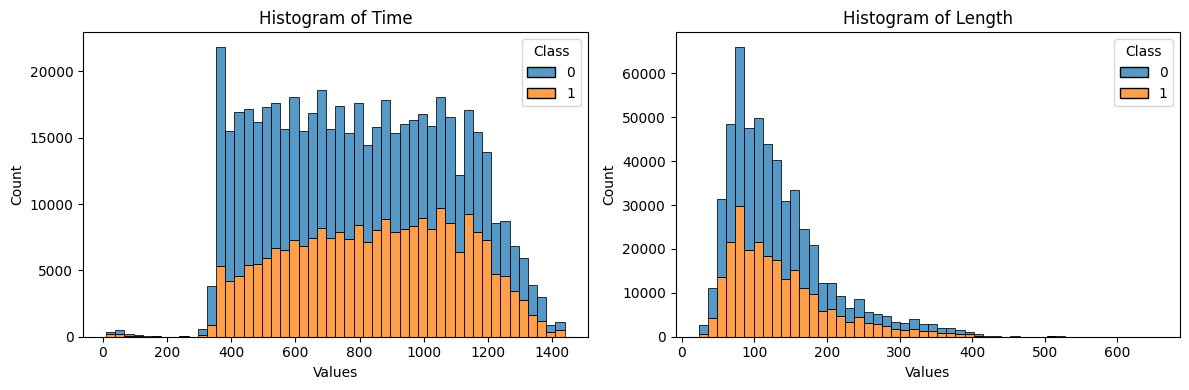

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#Histogram of feature Time
sns.histplot(data=dataset,x=dataset.Time,ax=axs[0],bins=50, hue='Class',multiple='stack');
axs[0].set_xlabel("Values")
axs[0].set_title('Histogram of Time')

#Histogram of feature Length
sns.histplot(data=dataset,x=dataset.Length,ax=axs[1],bins=50, hue='Class',multiple='stack');
axs[1].set_xlabel("Values")
axs[1].set_title('Histogram of Length')
plt.tight_layout()
plt.show()

**We see that for Time we have a fairly constant distribution (for both Class values), and for Length we have a distribution skewed to the right (for both Class values). In order to get a more normal distribution for Length we will perform a transformation on it.**

<h1><u><b>Data preparation</b></u></h1>

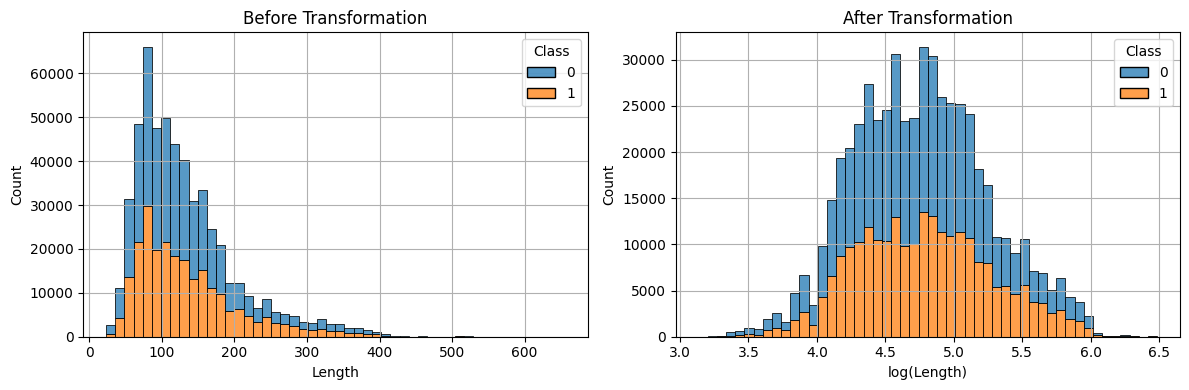

In [17]:
dataset['Length_Log'] = np.log(dataset['Length'])
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#Plotting histogram of Length before transformation
sns.histplot(data=dataset, x='Length', bins=50,ax=axs[0], hue='Class', multiple='stack')
axs[0].set_title('Before Transformation')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Count')
axs[0].grid(True)

#Plotting histogram of Length after Log transformation
sns.histplot(data=dataset, x='Length_Log', bins=50,ax=axs[1], hue='Class', multiple='stack')
axs[1].set_title('After Transformation')
axs[1].set_xlabel('log(Length)')
axs[1].set_ylabel('Count')
axs[1].grid(True)
plt.tight_layout()
plt.show()

**We can now replace the original Length with Length_Log.**

In [18]:
dataset['Length'] = dataset['Length_Log']
dataset.drop(columns='Length_Log',inplace=True)
dataset.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
Flight,,,,,,,
2313,1296.0,4.948760,DL,ATL,HOU,1,0
6948,360.0,4.983607,OO,COS,ORD,4,0
1247,1170.0,4.962845,B6,BOS,CLT,3,0
31,1410.0,5.840642,US,OGG,PHX,6,0
563,692.0,4.584967,FL,BMI,ATL,4,0


In [19]:
#We need to standardize the features: Time, and Length
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataset[['Time','Length']] = sc.fit_transform(dataset[['Time','Length']])
dataset.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
Flight,,,,,,,
2313,1.774068,0.381908,DL,ATL,HOU,1,0
6948,-1.592289,0.453043,OO,COS,ORD,4,0
1247,1.320904,0.410660,B6,BOS,CLT,3,0
31,2.184073,2.202579,US,OGG,PHX,6,0
563,-0.398240,-0.360731,FL,BMI,ATL,4,0


In [20]:
#We now need to encode our categorical features
categorical_features = ['Airline','AirportFrom','AirportTo','DayOfWeek']
#For certain models we require drop_first=True so that we avoid the dummy variable trap
#For other models we can have drop_first=False
dataset_dropfirst = pd.get_dummies(data=dataset,columns=categorical_features, drop_first=True, dtype='int')
dataset_nondropfirst = pd.get_dummies(data=dataset,columns=categorical_features, drop_first=False, dtype='int')

In [21]:
#Let's move the Class column back to the end
classColumn = dataset_dropfirst.pop('Class')
dataset_dropfirst = pd.concat([dataset_dropfirst,classColumn],axis=1)
classColumn = dataset_nondropfirst.pop('Class')
dataset_nondropfirst = pd.concat([dataset_nondropfirst,classColumn],axis=1)

In [22]:
#Lastly, let's see the distribution of our target column Class.
print(f"Distribution of target column: {dataset['Class'].sum()/dataset.shape[0]*100:.2f}%")

Distribution of target column: 44.54%


**Our target column is fairly evenly distributed and hence we can use the accuracy metric to give a good indicator to our model's strength.**

In [23]:
#Let's create our X (independant variables) and y (dependant variable)
X_dropfirst = dataset_dropfirst.iloc[:,0:-1].values
y_dropfirst = dataset_dropfirst.iloc[:,-1].values
X_nondropfirst = dataset_nondropfirst.iloc[:,0:-1].values
y_nondropfirst = dataset_nondropfirst.iloc[:,-1].values

In [24]:
#Splitting datasets into the Training set (80%), and Test set (20%)
from sklearn.model_selection import train_test_split
#1. for drop_first=True
X_train_dropfirst, X_test_dropfirst, y_train_dropfirst, y_test_dropfirst = train_test_split(X_dropfirst, y_dropfirst, test_size = 0.2, random_state = 0)
#2. for drop_first=False
X_train_nondropfirst, X_test_nondropfirst, y_train_nondropfirst, y_test_nondropfirst = train_test_split(X_nondropfirst, y_nondropfirst, test_size = 0.2, random_state = 0)

In [25]:
#delete unused variables to free up space
del X_dropfirst
del y_dropfirst
del X_nondropfirst
del y_nondropfirst
del dataset_dropfirst
del dataset_nondropfirst
del dataset

**We will try multiple machine learning model algorithms to find the best one for this problem.**

<h1><u><b>Building and training models</b></u></h1>

In [26]:
#Import libraries
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,make_scorer,roc_auc_score
#Define F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)

<h3><u><b>1. Decision Tree (XGBoost)</b></u></h3>

In [27]:
from xgboost import XGBClassifier

**The following hidden code cell takes long to run and hence has been commented out. I have put the output in a markdown cell below.**

In [28]:
'''
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
from datetime import datetime
#Define an objective function to be maximized.
def objective(trial):
    #Define hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
    }

    #Create XGBClassifier with the suggested hyperparameters
    scale_pos_weight = (len(y_train_nondropfirst)-sum(y_train_nondropfirst))/sum(y_train_nondropfirst)
    model = XGBClassifier(**params,objective='binary:logistic',scale_pos_weight=scale_pos_weight,
                          booster='gbtree',eval_metric='error',seed=42,verbosity=0)

    # Evaluate the model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_nondropfirst, y_train_nondropfirst, n_jobs=-1, cv=cv,scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy

#Create a study object and optimize the objective function.
current_datetime = datetime.now()
print("Current Date and Time:", current_datetime)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
current_datetime = datetime.now()
print("Current Date and Time:", current_datetime)
print(f"Best score: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")''';

**Best parameters: {'learning_rate': 0.255734133580646, 'max_depth': 10, 'subsample': 0.7648391310306696, 'colsample_bytree': 0.9824784878899909, 'reg_lambda': 0.008181248864207867, 'reg_alpha': 3.806969128214734}**

In [29]:
#Build optimal Decision Tree XGBoost Model
scale_pos_weight = (len(y_train_nondropfirst)-sum(y_train_nondropfirst))/sum(y_train_nondropfirst)
xgbModel = XGBClassifier(learning_rate= 0.255734133580646,max_depth= 10,subsample= 0.7648391310306696,colsample_bytree= 0.9824784878899909,
                         reg_lambda= 0.008181248864207867,reg_alpha= 3.806969128214734,objective='binary:logistic',
                         scale_pos_weight=scale_pos_weight,booster='gbtree',eval_metric='error',seed=42,verbosity=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgbModel,X_train_nondropfirst,y_train_nondropfirst,cv=cv,scoring='accuracy')
print(f"Average accuracy score from Cross-Validation: {np.mean(scores)}")

Average accuracy score from Cross-Validation: 0.6636168608071646


In [30]:
#Train model on entire training set and predict on Test set
xgbModel.fit(X_train_nondropfirst,y_train_nondropfirst);
y_pred = xgbModel.predict(X_test_nondropfirst)

In [31]:
#Displaying model's performance on Train, and Test set
print("Decision Tree (XGBoost) Model's performance on Train, and Test set:")
print("The model's accuracy on the training set is: " + str(xgbModel.score(X_train_nondropfirst,y_train_nondropfirst)))
print("The model's accuracy on the test set is: " + str(accuracy_score(y_test_nondropfirst,y_pred)))
print("The model's precision on the test set is: " + str(precision_score(y_test_nondropfirst,y_pred)))
print("The model's recall on the test set is: " + str(recall_score(y_test_nondropfirst,y_pred)))
print("The model's f1_score on the test set is: " + str(f1_score(y_test_nondropfirst,y_pred)))
print("The model's roc_auc_score on the test set is: " + str(roc_auc_score(y_test_nondropfirst,y_pred)))

Decision Tree (XGBoost) Model's performance on Train, and Test set:
The model's accuracy on the training set is: 0.6892876510421736
The model's accuracy on the test set is: 0.6627887574622715
The model's precision on the test set is: 0.6217415883252025
The model's recall on the test set is: 0.6185685122692997
The model's f1_score on the test set is: 0.6201509914688776
The model's roc_auc_score on the test set is: 0.6584073561847584


**We will now try a neural network model.**

<h3><u><b>2. ANN (Artificial Neural Network)</b></u></h3>

In [32]:
#Import the libraries
import keras
from keras.layers import Dense, PReLU, Dropout
from keras.regularizers import l2
from keras.losses import BinaryCrossentropy
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [33]:
#Build ANN model
annFinal = keras.models.Sequential()
annFinal.add(Dense(units=1000, activation='relu', input_shape=X_train_dropfirst[0].shape))
annFinal.add(Dropout(0.2))
annFinal.add(Dense(units=500, activation='relu',kernel_regularizer=l2(0.01)))
annFinal.add(Dropout(0.1))
annFinal.add(Dense(units=76, activation='relu',kernel_regularizer=l2(0.01)))
annFinal.add(Dense(units=1, activation='linear'))
#Run the model
annFinal.compile(optimizer = Adam(0.01), loss = BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
hist = annFinal.fit(X_train_dropfirst, y_train_dropfirst, batch_size = 128, epochs = 10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1731187271.311302      75 service.cc:145] XLA service 0x7bc3dc00a280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731187271.311341      75 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731187271.311345      75 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  72/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5814 - loss: 2.0191

I0000 00:00:1731187275.276499      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3372/3372 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6224 - loss: 0.7219
Epoch 2/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6338 - loss: 0.6565
Epoch 3/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6372 - loss: 0.6428
Epoch 4/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6394 - loss: 0.6373
Epoch 5/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6407 - loss: 0.6353
Epoch 6/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6434 - loss: 0.6326
Epoch 7/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6446 - loss: 0.6327
Epoch 8/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6466 - loss: 0.6302
Epoch 9/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6461 - loss: 0.6314
Epoch 10/10
3372/3372 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6479 - loss: 0.6273


In [34]:
#Prediction on Train set
logits = annFinal(X_train_dropfirst)
y_pred_train = tf.nn.sigmoid(logits)
y_pred_train = (y_pred_train > 0.5)
#Prediction on Test set
logits = annFinal(X_test_dropfirst)
y_pred_test = tf.nn.sigmoid(logits)
#We will use a threshold of 50%
y_pred_test = (y_pred_test > 0.5)

In [35]:
#Displaying model's performance on Train, and Test set
print("ANN Model's performance on Train, and Test set:")
print(f"The model's accuracy on the training set is: {accuracy_score(y_train_dropfirst,y_pred_train)}")
print("The model's accuracy on the test set is: " + str(accuracy_score(y_test_dropfirst,y_pred_test)))
print("The model's precision on the test set is: " + str(precision_score(y_test_dropfirst,y_pred_test)))
print("The model's recall on the test set is: " + str(recall_score(y_test_dropfirst,y_pred_test)))
print("The model's f1_score on the test set is: " + str(f1_score(y_test_dropfirst,y_pred_test)))
print("The model's roc_auc_score on the test set is: " + str(roc_auc_score(y_test_dropfirst,y_pred_test)))

ANN Model's performance on Train, and Test set:
The model's accuracy on the training set is: 0.6776654569387859
The model's accuracy on the test set is: 0.662825837072194
The model's precision on the test set is: 0.6671552145299883
The model's recall on the test set is: 0.4835853851601883
The model's f1_score on the test set is: 0.5607284760214003
The model's roc_auc_score on the test set is: 0.6450664523930222


**We have a model that does not overfit or underfit - this is good. However, despite tuning the model, its accuracy remains low.<br>Our two models give very similar accuracies, but we can see that on the other metrics XGBoost scores higher.**

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c1e3e5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
Thank you for reading through my notebook. I hope you enjoyed it and found it interesting☺️. I will also reply to any comments you have on this notebook. Have a good day!🚀
</p>
</div>